In [38]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import time 

## TP7 :

In [ ]:
def simulation_w1_w2(T , N , rho):
    incr_1 = np.sqrt(T/N)*np.random.randn(N)
    W_1 = np.concatenate(([0.] ,np.cumsum(incr_1)))
    
    incr_2 = np.sqrt(T/N)*np.random.randn(N)
    W_3 = np.concatenate(([0.] ,np.cumsum(incr_2)))
    
    W_2 = rho*W_1 + np.sqrt(1- rho**2)*W_3 
    
    return (W_1 , W_2)


def schema_s_v(s_0 , v_0 ,  k_v , theta , T , N  , sigma , r , W_1 , W_2):
    
    # W_1 , W_2 = simulation_w1_w2(T,N,rho)
    
    S = np.zeros(N+1)
    V = np.zeros(N+1)
    S[0]= s_0 
    V[0] = v_0
    
    for k in range(1,N+1) :
        V[k] = V[k-1] + k_v*(theta - V[k-1])*(T/N) + sigma*np.sqrt(max(V[k-1] , 0))*(W_2[k] - W_2[k-1])
        S[k] = S[k-1] + r*S[k-1]*(T/N) + np.sqrt(max(V[k-1] , 0))*S[k-1]*(W_1[k] - W_1[k-1])
        
        
    return (S,V)



def calcul_W1_W2_suiv(W_1 , W_2 , m , l) :
    """
    """
    taille2 = m**(l-1)
    W_1_suiv = np.zeros(taille2 + 1)
    W_2_suiv = np.zeros(taille2 + 1)

    for i in range(taille2 + 1) :
        W_1_suiv[i] = W_1[i*m]
        W_2_suiv[i] = W_2[i*m]

    return W_1_suiv , W_2_suiv
    


def approximate_A(t , S , N) :
    res = (t/N)*(sum(S) - 0.5*(S[0] + S[-1]))
    return res 
    
    
def payoff(T , S , K , N):
    
    return max((1/T)*approximate_A(T,S,N) - K , 0 )
    
    

def price_mc(M , s_0 , v_0 ,  k_v , theta , T , N , rho , sigma , r , K ):
    
    price = 0
    for _ in range(M) :
        W_1 , W_2 = simulation_w1_w2(T,N,rho)
        S,_ = schema_s_v(s_0 , v_0 ,  k_v , theta , T , N  , sigma , r , W_1 , W_2 )
        p = payoff(T , S , K ,N)
        price += p
        
    price = price*np.exp(-r*T) / M 
    
    return price 


def MSE(M , s_0 , v_0 ,  k_v , theta , T , N , rho , sigma , r , K , price_exacte , M_2 ) :
    """
    
    """
    start = time.time()
    MSE = 0
    for _ in range(M_2) :
        S_M = price_mc(M , s_0 , v_0 ,  k_v , theta , T , N , rho , sigma , r , K)
        MSE += (S_M - price_exacte)**2 

    MSE = MSE / M_2
    end = time.time()

    temps_calcul = end - start 

    return MSE , temps_calcul

    
def calcul_Ml(m , L , l , epsilon) :
    a = m**l
    b = epsilon**2
    return int(L/(a*b))

def price_mc_multi(s_0 , v_0 ,  k_v , theta , T ,  rho , sigma , r , K , m , epsilon ):
    """ 
    
    """
    L = int(np.log(1/epsilon) / np.log(m) )
    M_0 = calcul_Ml(m , L , 0 , epsilon)
    price = price_mc(M_0 ,s_0 , v_0 ,  k_v , theta , T , m**0 , rho , sigma , r , K )

    for l in range(1,L):
        Ml = calcul_Ml(m , L , l , epsilon)
        price_l = 0 
        for _ in range(1 , Ml):
            # les browniens de schéma à m**l dates : 
            W_1 , W_2 = simulation_w1_w2(T,m**l,rho)
            # schéma à m**l dates : 
            S,_ = schema_s_v(s_0 , v_0 ,  k_v , theta , T , m**l  , sigma , r , W_1 , W_2)
            price_l += payoff(T , S , K ,m**l)
            # schéma à m**(l-1) dates :
            W_1 , W_2 = calcul_W1_W2_suiv(W_1 , W_2 , m , l)
            S,_ = schema_s_v(s_0 , v_0 ,  k_v , theta , T , m**(l-1)  , sigma , r , W_1 , W_2)
            price_l -= payoff(T , S , K ,m**(l- 1))
        price_l = price_l / Ml 
        price += price_l
    
    return price


def MSE_multi(s_0 , v_0 ,  k_v , theta , T ,  rho , sigma , r , K  ,m , epsilon , M_2 , prix_exacte):
    """ 
    
    """
    start = time.time()
    MSE = 0
    for _ in range(M_2) :
        S_M = price_mc_multi(s_0 , v_0 ,  k_v , theta , T ,  rho , sigma , r , K   ,m , epsilon)
        MSE += (S_M - prix_exacte)**2 

    MSE = MSE / M_2
    
    end = time.time()
    temps_calcul = end - start 
    return MSE , temps_calcul
    


def Courbe_MSE_Temps_multi(s_0 , v_0 ,  k_v , theta , T ,  rho , sigma , r , K  ,m , epsilon , M_2 , prix_exacte , nbpts) :

    data = [MSE_multi(s_0 , v_0 ,  k_v , theta , T ,  rho , sigma , r , K  ,m , epsilon , M_2 , prix_exacte) for i in range(nbpts)]

    mse = [data[i][0] for i in range(nbpts)]
    temps = [data[i][1] for i in range(nbpts)]
    print(temps)
    print(mse)

    plt.scatter(mse , temps , label = "MC Multi-Level")
    plt.legend()
    plt.show()


In [48]:
r = 0.03
s_0  = 100
K = 110
T = 2
rho = -0.2
v_0 = 0.04
k_v = 2
theta = 0.04
sigma = 0.01
N = 100
M = 10000
prix_exacte = 3.847906
M_2 = 10
m = 2
epsilon = 10e-2


In [44]:
# MC Classique : 
price = price_mc(M ,s_0 , v_0 , k_v , theta , T , N , rho , sigma ,r, K )
print(f"price avec une méthode de MC Classique : {price}")

price avec une méthode de MC Classique : 3.8444980995301847


In [ ]:
# MSE MC Classique 
mse = MSE(M ,s_0 , v_0 , k_v , theta , T , N , rho , sigma ,r, K, prix_exacte , M_2 )
print(f"MSE MC Classique = {mse[0]} avec un temps de calcul égale à {mse[1]} secondes")

MSE MC Classique = 0.005035127498357737 avec un temps de calcul égale à 56.91708278656006


In [53]:
# MC Multi-niveaux : 
price_multi = price_mc_multi(s_0 , v_0 ,  k_v , theta , T ,  rho , sigma , r , K , m , epsilon)
print(f"price avec une méthode de MC Multi-Level  = {price_multi}")


price avec une méthode de MC Multi-Level  = 3.897844426747593


In [77]:
# MSE en fonction de temps de calcul : 
mse_multi = MSE_multi(s_0 , v_0 ,  k_v , theta , T ,  rho , sigma , r , K  ,m , epsilon , M_2 , prix_exacte)
print(f"MSE MC Multi-Level = {mse_multi[0]} avec un temps de calcul égale à {mse_multi[1]} secondes ")

MSE MC Multi-Level = 0.1540122143888402 avec un temps de calcul égale à 0.4815652370452881 secondes 


[0.3535645008087158, 0.25858306884765625, 0.3572268486022949, 0.31471729278564453, 0.34700441360473633, 0.27732324600219727, 0.4914693832397461, 0.5344803333282471, 0.3487358093261719, 0.3005862236022949]
[0.4477170540280759, 0.32053018960969254, 0.2990554679037373, 0.3134278681373907, 0.17636801808511005, 0.10859016804441537, 0.19987672630322775, 0.24981118029427787, 0.4985419032848425, 0.3926470014461967]


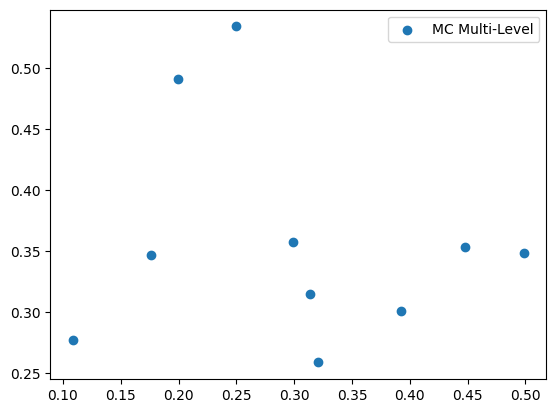

In [81]:
# Courbe : 
nbpts = 10 
Courbe_MSE_Temps_multi(s_0 , v_0 ,  k_v , theta , T ,  rho , sigma , r , K  ,m , epsilon , M_2 , prix_exacte , nbpts)